## Chapter 7: Policy Gradient Methods

### Policy-based Reinforcement Learning

In previous chapters, we focused on learning value function and generate policy from it. Yet there are RL algorithms that directly generate the policy from experience: **Policy-based RL**.

In policy-based RL, we use parametrized policy by differentiable parameter $\theta$. 
</br>
</br>
<font size="3">
$$\begin{align}
\pi_\theta(a|s) = \mathbb{P}[a |s, \theta]
\end{align}$$
</font>

Policy-based RL is effective in **high-dimensional** or **continuous action spaces**, and able to learn **stochastic policies**.


#### Policy Gradient Theorem

In policy gradient, policy parameter $\theta$ is updated by some scalar performance measure $\mathcal{J}(\theta)$ with respect to the policy parameter. To maximize policy performance, their updates approximate **gradient ascent** in $\mathcal{J}$:
</br>
</br>
<font size="3">
$$\begin{align}
\theta_{t+1} = \theta_t + \alpha \nabla \mathcal{J}(\theta_t)
\end{align}$$
</font>

where $\alpha$ is a step-size parameter..

Then what can be the performance measure $\mathcal{J}(\theta)$ for MDP policy in finite episode?

In episodic case trajectory $\tau$. Then, we can define $\mathcal{J}(\theta)$ as its value.
</br>
</br>
<font size="3">
$$\begin{align}
\mathcal{J}(\theta) = \sum_{s \in \mathcal{S}} d^\pi(s)v_\pi(s) = \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(a|s) q_\pi(s, a)
\end{align}$$
</font>
where $d^\pi$ is the stationary distribution for Markov chain for $\pi_\theta$.

Then gradient of $\mathcal{J}$ can be reformatted as the following:
</br>
</br>
<font size="3">
$$\begin{align}
\nabla_\theta \mathcal{J}(\theta) = \nabla_\theta \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(a|s) Q_\pi(s, a) & \\
\propto \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} Q_\pi(s, a) \nabla_\theta \pi_\theta(a|s) \\
 = \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(s, a) Q_\pi(s, a) \dfrac{\nabla_\theta \pi_\theta(a|s)}{\pi_\theta(a|s)} \\ 
= \mathbb{E}_\pi [Q_\pi(s,a) \nabla_\theta \log \pi_\theta(s,a)]
\end{align}$$
</font>

where $\mathbb{E}_\pi$ refers to $\mathbb{E}_{s \sim d_\pi, a \sim \pi_\theta}$ and $Q_\pi$ means **true state-value** under policy $\pi$. 


### Monte-Carlo Policy Gradient


As gradient of the policy performance measure $\mathcal{J}$ can be expressed as the following:
</br>
</br>
<font size="3">
$$\begin{align}
\nabla_\theta \mathcal{J}(\theta) = \mathbb{E}_\pi [q_\pi(s,a) \nabla_\theta \log \pi_\theta(s,a)]
\end{align}$$
</font>

we have to calculate true state-value $Q_\pi$. 

Classical policy gradient algorithm **REINFORCE** uses **return** $G_t$ for $Q_\pi$, as 
</br>
</br>
<font size="3">
$$\begin{align}
\mathbb{E}_\pi [G_t|s_t, a_t] = Q_\pi (s_t, a_t)
\end{align}$$
</font>

To calculate return, policy update is done at the end of the every episode as the following.

#### REINFORCE

After generating an episode $s_0, a_0, r_0, ..., s_{T-1}, a_{T-1}, r_T$, following policy $\pi_\theta$,

For each episode step $t = 0, 1, ... , T-1$
</br>
</br>
<font size="3">
$$\begin{align}
G_t \leftarrow \sum_{k=t+1}^T \gamma^{k-t-1}r_k \\ 
\theta \leftarrow \theta + \alpha \gamma^t G_t \nabla_\theta \log \pi_\theta (a_t|s_t)
\end{align}$$
</font>



### Pseudocode and Implementation of REINFORCE

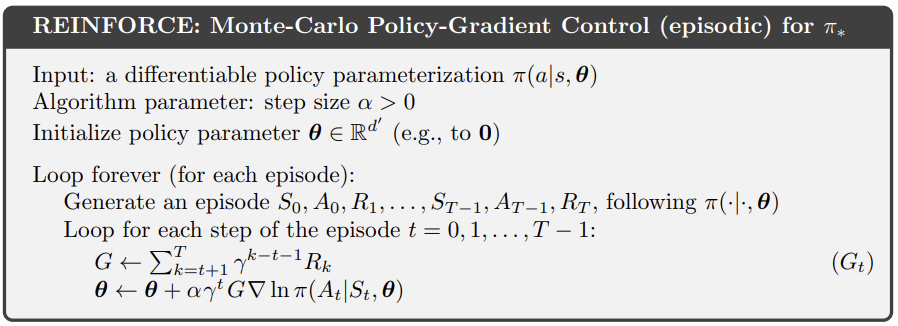


In [9]:
import gymnasium as gym
import matplotlib
import IPython
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from utils import JupyterRender
from functools import reduce

# To implement differentiable policy with ease, ML framework like tensorflow or pytorch is needed.
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline

In [10]:
class Policy_network(tf.keras.Model):
    def __init__(self, state_dim, action_dim, hidden_units=(64, 64), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'):
        super(Policy_network, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.input_layer = tf.keras.layers.InputLayer(input_shape=(self.state_dim, ), dtype=tf.float32, name='input')
        self.hidden_layers = []
        for i in range(len(hidden_units)):
            self.hidden_layers.append(tf.keras.layers.Dense(hidden_units[i], activation=activation, kernel_initializer=kernel_initializer,
                                                            bias_initializer=bias_initializer, name='dense{}'.format(i)))

        self.output_layer = tf.keras.layers.Dense(self.action_dim, kernel_initializer=kernel_initializer,
                                                  bias_initializer=bias_initializer, name='output')

        self(tf.zeros(shape=(1,) + (self.state_dim,), dtype=tf.float32))

    @tf.function
    def call(self, input, activation='softmax'):

        z = self.input_layer(input)

        for layer in self.hidden_layers:
            z = layer(z)

        output = self.output_layer(z)
        output = tf.keras.activations.get(activation)(output)

        return output

In [11]:
class REINFORCE:
    def __init__(self, env, gamma=0.9, alpha=0.001, render=False, max_episode=1000):
        self.env = env
        self.state_dim = env.observation_space.n
        self.action_dim = env.action_space.n
        
        self.nrow = env.nrow
        self.ncol = env.ncol 
        
        self.gamma = gamma
        self.alpha = alpha
        
        self.max_episode = max_episode
        self.render = render

        self.policy = Policy_network(self.state_dim, self.action_dim)
        self.optimizer = tf.keras.optimizers.Adam(self.alpha)

    def action(self, s):
        s = np.eye(self.state_dim)[s] # one-hot encoding
        s = np.expand_dims(s, axis=0) # expand state dimension

        policy = self.policy(s)
        dist = tfp.distributions.Categorical(probs=policy)
        action = dist.sample().numpy()

        action = action[0]

        return action

    def run(self):
        self.success = 0

        for episode in range(self.max_episode):
            observation, _ = self.env.reset()

            done = False
            episode_reward = 0
            local_step = 0

            trajectory = []
            policy_prob = self.policy(np.eye(self.state_dim)).numpy()

            while not done:
                action = self.action(observation)
                next_observation, reward, done, _, _ = self.env.step(action)

                if self.render:
                    self.env.render(title=f"Episode {episode} / step {local_step}", policy=policy_prob)

                # give penalty for staying in ground
                if reward == 0:
                    reward = -0.001

                # give penalty for falling into the hole
                if done and next_observation != 15:
                    reward = -1

                if local_step == 100:
                    done = True #prevent infinite episode
                    reward = -1

                if observation == next_observation: # prevent meaningless actions
                    reward = -1

                trajectory.append({"s": observation, "a": action, "r": reward})

                observation = next_observation

                episode_reward += reward
                local_step += 1
            #print("Episode: {} -> Step: {}, Episode_reward: {}".format(episode, local_step, episode_reward))

            if observation == 15:
                self.success += 1

            reward_list = np.array(list(map(lambda x: x['r'], trajectory)))

            for i in range(len(trajectory)):
                with tf.GradientTape() as tape:
                    G = reduce(lambda acc, x: acc+(self.gamma ** x[0])*x[1], enumerate(reward_list[i:]), 0)

                    s = np.eye(self.state_dim)[trajectory[i]['s']] # one-hot encoding
                    s = np.expand_dims(s, axis=0) # expand state dimension

                    policy = self.policy(s)
                    dist = tfp.distributions.Categorical(probs=policy)
                    log_policy = tf.reshape(dist.log_prob(trajectory[i]['a']), (-1, 1))

                    loss = -(self.gamma**i) * G * log_policy

                variables = self.policy.trainable_variables
                gradients = tape.gradient(loss, variables)

                self.optimizer.apply_gradients(zip(gradients, variables))

        #print("Success rate: ", self.success / self.max_episode)

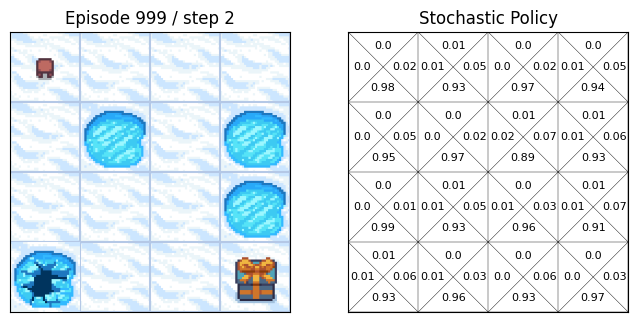

In [12]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

config = {
    'env': env,
    'gamma': 0.99,
    'alpha': 0.001,
    'render': True,
    'max_episode': 1000
}

reinforce = REINFORCE(**config)
reinforce.run()


### Actor-Critic Policy Gradient

Yet the algorithm **REINFORCE** has a disadvantage in high gradient variance. 
.
Thus, to reduce variance **critic** can be used instead of **return** to estimate $Q_\pi$.
</br>
</br>
<font size="3">
$$\begin{align}
q_\phi (s, a) = Q_\pi(s, a)
\end{align}$$
</font>

Therefore policy gradient is changed as
</br>
</br>
<font size="3">
$$\begin{align}
\nabla_\theta \mathcal{J}(\theta) = \mathbb{E}_\pi [q_\phi(s,a) \nabla_\theta \log \pi_\theta(s,a)]\\
\theta \leftarrow \theta + \alpha \nabla_\theta \log \pi_\theta (a_t|s_t) q_\phi(s_t, a_t)
\end{align}$$
</font>

And how we can update the critic $q_\phi$? There exists many different methods:

- Monte-Carlo evaluation
- TD(0)
- TD($\lambda$)

For example, if we use TD(0), then in timestep $t$ critic will be updated as
</br>
</br>
<font size="3">
$$\begin{align}
\phi \leftarrow \phi + \beta (r_t + \gamma q_\phi(s_{t+1}, a_{t+1}) - q_\phi(s_t, a_t)) \nabla_\phi q_\phi(s_t, a_t)
\end{align}$$
</font>

#### Reducing a variance using baseline

We can further reduce the variance of the policy gradient by subtracting baseline $B(s)$ from the policy gradient. 

A good baseline can be state value $V_\pi$. 
</br>
</br>
<font size="3">
$$\begin{align}
A_\pi(s, a) = Q_\pi(s, a) - V_\pi(s)
\end{align}$$
</font>

$A_\pi$ is called **Advantage**. It can be intuitively thought as advantage of taking certain action in certain state $s$. 

Considering there are **states** that are more likely to achieve higher reward compared to other states (regardless of policy action), advantage can be better indicator for policy gradient.

Furthermore, we can use TD target, approximating advantage to TD error.
</br>
</br>
<font size="3">
$$\begin{align}
A_\pi(s, a) \doteq r + V_\pi(s') - V_\pi(s)
\end{align}$$
</font>


### Pseudocode of Actor-Critic

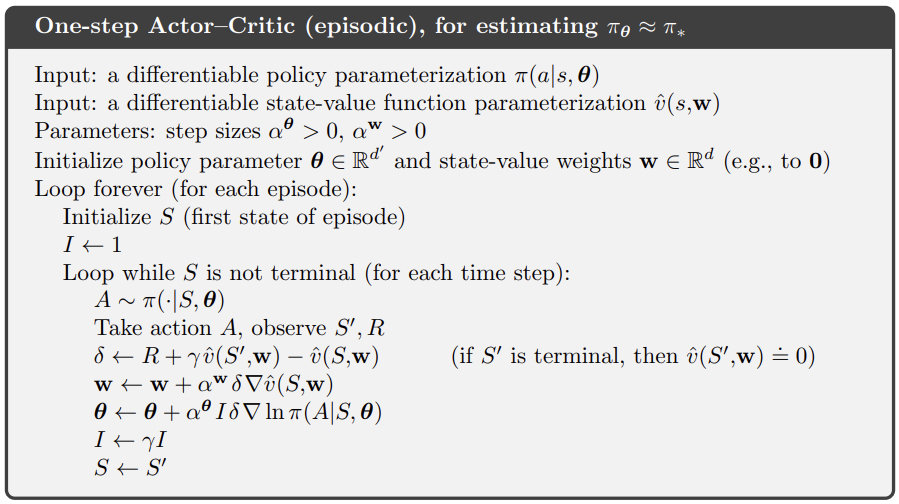


In [1]:
import gymnasium as gym
import matplotlib
import IPython
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from utils import JupyterRender

# To implement differentiable policy with ease, ML framework like tensorflow or pytorch is needed.
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline

In [29]:
class Policy_network(tf.keras.Model):
    def __init__(self, state_dim, action_dim, hidden_units=(64, 64), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'):
        super(Policy_network, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.input_layer = tf.keras.layers.InputLayer(input_shape=(self.state_dim, ), dtype=tf.float32, name='input')
        self.hidden_layers = []
        for i in range(len(hidden_units)):
            self.hidden_layers.append(tf.keras.layers.Dense(hidden_units[i], activation=activation, kernel_initializer=kernel_initializer,
                                                            bias_initializer=bias_initializer, name='dense{}'.format(i)))

        self.output_layer = tf.keras.layers.Dense(self.action_dim, kernel_initializer=kernel_initializer,
                                                  bias_initializer=bias_initializer, name='output')

        self(tf.zeros(shape=(1,) + (self.state_dim,), dtype=tf.float32))

    @tf.function
    def call(self, input, activation='softmax'):

        z = self.input_layer(input)

        for layer in self.hidden_layers:
            z = layer(z)

        output = self.output_layer(z)
        output = tf.keras.activations.get(activation)(output)

        return output

In [30]:
class Value_network(tf.keras.Model):
    def __init__(self, state_dim, hidden_units=(64, 64), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'):
        super(Value_network, self).__init__()
        self.state_dim = state_dim

        self.input_layer = tf.keras.layers.InputLayer(input_shape=(self.state_dim, ), dtype=tf.float32, name='input')
        self.hidden_layers = []
        for i in range(len(hidden_units)):
            self.hidden_layers.append(
                tf.keras.layers.Dense(hidden_units[i], activation=activation, kernel_initializer=kernel_initializer,
                                      bias_initializer=bias_initializer, name='dense{}'.format(i)))

        self.output_layer = tf.keras.layers.Dense(1, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, name='output')

        self(tf.zeros(shape=(1,) + (self.state_dim,), dtype=tf.float32))

    @tf.function
    def call(self, input):
        z = self.input_layer(input)
        for layer in self.hidden_layers:
            z = layer(z)

        output = self.output_layer(z)

        return output

In [31]:
class Actor_Critic:
    def __init__(self, env, gamma=0.9, alpha_a=0.001, alpha_c=0.001, render=False, max_episode=1000):
        self.env = env
        self.state_dim = env.observation_space.n
        self.action_dim = env.action_space.n

        self.nrow = env.nrow
        self.ncol = env.ncol

        self.gamma = gamma
        self.alpha_a = alpha_a
        self.alpha_c = alpha_c

        self.max_episode = max_episode
        self.render = render

        self.actor = Policy_network(self.state_dim, self.action_dim)
        self.critic = Value_network(self.state_dim)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.alpha_a)
        self.critic_optimizer = tf.keras.optimizers.Adam(self.alpha_c)

    def action(self, s):
        s = np.eye(self.state_dim)[s] # one-hot encoding
        s = np.expand_dims(s, axis=0) # expand state dimension

        policy = self.actor(s)
        dist = tfp.distributions.Categorical(probs=policy)
        action = dist.sample().numpy()

        action = action[0]

        return action

    def run(self):
        self.success = 0

        for episode in range(self.max_episode):
            observation, _ = self.env.reset()

            done = False
            episode_reward = 0
            local_step = 0

            I = 1

            while not done:
                action = self.action(observation)
                next_observation, reward, done, _, _ = self.env.step(action)

                if self.render:
                    self.env.render(title=f"Episode {episode} / step {local_step}", policy=self.actor(np.eye(self.state_dim)).numpy(), v=self.critic(np.eye(self.state_dim)).numpy().reshape(-1))

                # give penalty for staying in ground
                if reward == 0:
                    reward = -0.001

                # give penalty for falling into the hole
                if done and next_observation != 15:
                    reward = -1

                if local_step == 100:
                    done = True #prevent infinite episode
                    reward = -1

                if observation == next_observation: # prevent meaningless actions
                    reward = -1

                with tf.GradientTape(persistent=True) as tape:
                    observation_one_hot = np.eye(self.state_dim)[observation] # one-hot encoding
                    observation_one_hot = np.expand_dims(observation_one_hot, axis=0) # expand state dimension

                    next_observation_one_hot = np.eye(self.state_dim)[next_observation]
                    next_observation_one_hot = np.expand_dims(next_observation_one_hot, axis=0)

                    delta = reward + self.gamma * (1-done) * (self.critic(next_observation_one_hot) - self.critic(observation_one_hot))

                    policy = self.actor(observation_one_hot)
                    dist = tfp.distributions.Categorical(probs=policy)
                    log_policy = tf.reshape(dist.log_prob(action), (-1, 1))

                    critic_loss = -delta
                    actor_loss = -I * delta * log_policy

                critic_variables = self.critic.trainable_variables
                critic_gradients = tape.gradient(critic_loss, critic_variables)

                self.critic_optimizer.apply_gradients(zip(critic_gradients, critic_variables))

                actor_variables = self.actor.trainable_variables
                actor_gradients = tape.gradient(actor_loss, actor_variables)

                self.actor_optimizer.apply_gradients(zip(actor_gradients, actor_variables))

                I = self.gamma * I
                observation = next_observation

                episode_reward += reward
                local_step += 1

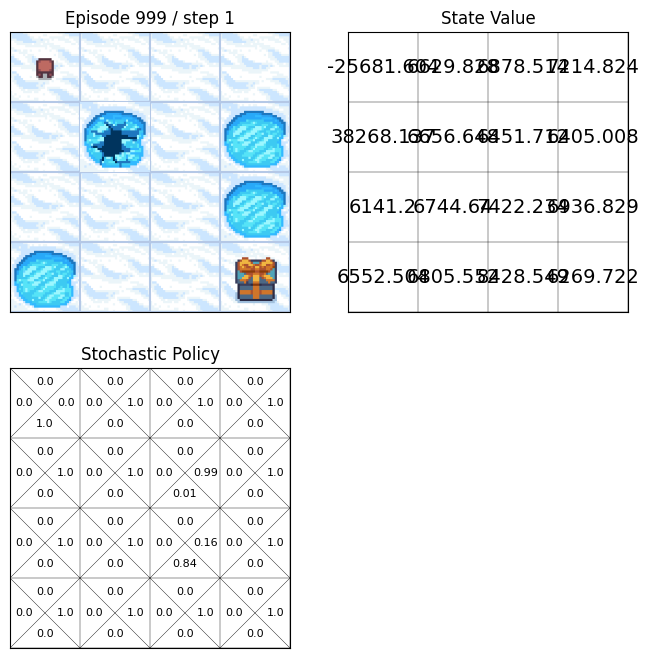

In [32]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

config = {
    'env': env,
    'gamma': 0.99,
    'alpha_a': 0.001,
    'alpha_c': 0.001,
    'render': True,
    'max_episode': 1000
}

actor_critic = Actor_Critic(**config)
actor_critic.run()